In [ ]:
import json

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
def read_mm_converted(mm_set_path):
    with open(mm_set_path, 'r') as json_f:
        mm_set = json.load(json_f)

    return list(mm_set['docs'])

In [ ]:
num_spans_train = 0
gold_labels_train = []
mm_docs = read_mm_converted('mm_converted.train.json')
for doc in mm_docs:
    for sentence in doc['sentences']:
        num_spans_train += len(sentence['spans'])
        for span in sentence['spans']:
            gold_labels_train.append(span['cui'].lstrip('UMLS:'))
assert len(gold_labels_train) == num_spans_train

In [ ]:
with open('ens_rerank.txt', 'r') as f:
    # Parse the JSON string
    data = json.load(f)

In [ ]:
for i in range(len(data['gold_labels'])):
  data['gold_labels'][i] = data['gold_labels'][i].lstrip("UMLS:")
gold_labels = np.array(data['gold_labels'])
pred_labels = np.array(data['pred_labels'])

In [ ]:
print(len(gold_labels))

37829


In [ ]:
gold_labels_set = set(gold_labels)
print(f"Number of unique labels found in test set: {len(gold_labels_set)}")

Number of unique labels found in test set: 8414


In [ ]:
training_counts = []
training_counts_dict = {}
for concept in gold_labels_set:
  count_in_training = gold_labels_train.count(concept)
  training_counts.append(count_in_training)
  training_counts_dict[concept] = count_in_training

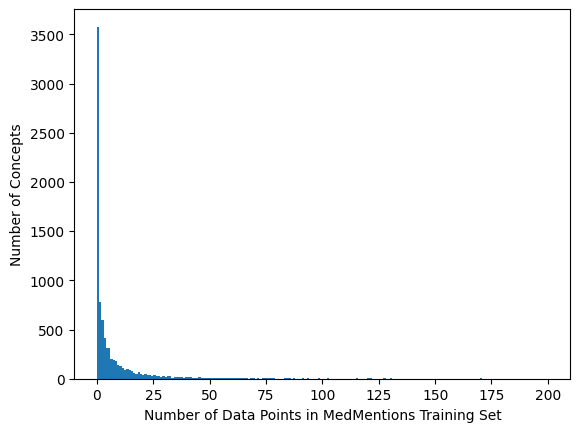

In [ ]:
plt.hist(training_counts, bins=200, range=[0, 200])
plt.ylabel('Number of Concepts')
plt.xlabel('Number of Data Points in MedMentions Training Set');

In [ ]:
training_counts.count(0)

3577

In [ ]:
indices = np.where(gold_labels == "C0229671")

In [ ]:
pred_labels[indices]

array(['C0229671', 'C0229671', 'C0229671', 'C0229671', 'C0229671',
       'C0229671', 'C0229671', 'C0229671', 'C0312586', 'C0229671',
       'C0229671', 'C0229671', 'C0229671', 'C0229671', 'C0229671',
       'C0229671', 'C0229671', 'C0229671', 'C0229671', 'C0229671',
       'C0229671', 'C0229671', 'C0229671', 'C0229671', 'C0229671',
       'C0229671', 'C0229671', 'C0229671', 'C0229671', 'C0229671',
       'C0229671'], dtype='<U8')

In [ ]:
test_cui = "C0229671"

In [ ]:
training_counts_dict[test_cui]

130

In [ ]:
tp = 0
fp = 0
for i in range(len(gold_labels)):
  if pred_labels[i] is not None:
    if gold_labels[i] == pred_labels[i]:
      tp += 1
    else:
      fp += 1

In [ ]:
fn = 0
for i in range(len(pred_labels)):
  if pred_labels[i] is None:
    fn += 1

In [ ]:
precision = tp/(tp+fp)
recall = tp/(tp+fn)
f1 = 2 * (precision * recall) / (precision + recall)
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1: {f1}")

Precision: 0.5107985936715218
Recall: 1.0
F1: 0.6761968085106382


In [ ]:
def compute_precision_of_concept(cui, golds, preds):
  relevant_indices = np.where(golds == cui)
  relevant_preds = preds[relevant_indices]
  tp1 = 0
  fp1 = 0
  for pred in relevant_preds:
    if pred is not None:
      if pred == cui:
        tp1 += 1
      else:
        fp1 += 1
  if tp1 + fp1 == 0:
    return 0
  return tp1 / (tp1+fp1)

In [ ]:
compute_precision_of_concept(test_cui, gold_labels, pred_labels)

0.967741935483871

In [ ]:
scatter_x = []
scatter_y = []
processed_count = 0
for test_cui in gold_labels_set:
  processed_count += 1
  precision = compute_precision_of_concept(test_cui, gold_labels, pred_labels)
  if processed_count % 1000 == 0 or processed_count == len(gold_labels_set):
    print(f"Example {processed_count}/{len(gold_labels_set)}")
  # print(f"Counts: {training_counts_dict[test_cui]}")
  # print(f"Precision: {precision}")
  scatter_x.append(training_counts_dict[test_cui])
  scatter_y.append(precision)

Example 1000/8414
Example 2000/8414
Example 3000/8414
Example 4000/8414
Example 5000/8414
Example 6000/8414
Example 7000/8414
Example 8000/8414
Example 8414/8414


In [ ]:
scatter_x = np.array(scatter_x)
scatter_y = np.array(scatter_y)

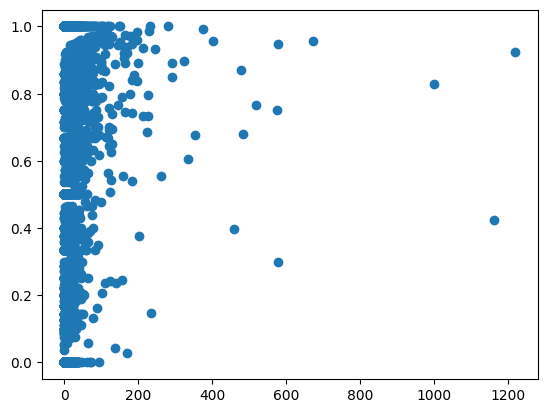

In [ ]:
plt.scatter(scatter_x, scatter_y)

In [ ]:
unique_x_counts = np.unique(scatter_x)
final_x_counts = []
average_precisions = []
for unique_x_count in unique_x_counts:
  corresponding_indices = np.where(scatter_x == unique_x_count)
  corresponding_precisions = scatter_y[corresponding_indices]
  if len(corresponding_indices[0]) >= 5:
    final_x_counts.append(unique_x_count)
    average_precisions.append(np.mean(corresponding_precisions))
  # print(np.mean(corresponding_precisions))
final_x_counts = np.array(final_x_counts)
average_precisions = np.array(average_precisions)

(-0.1, 1.1)

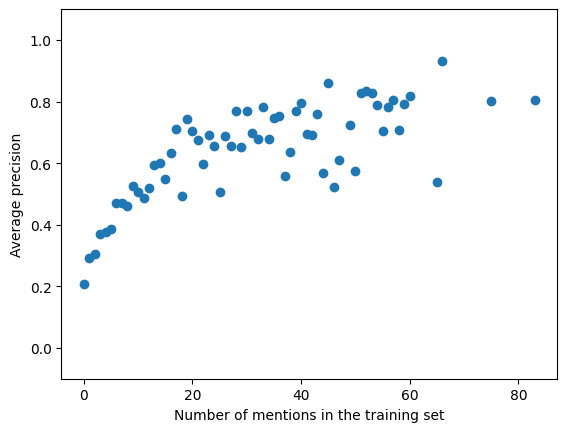

In [ ]:
plt.scatter(final_x_counts, average_precisions)
plt.xlabel("Number of mentions in the training set")
plt.ylabel("Average precision")
plt.ylim(-0.1, 1.1)